# Fig14. Founders according to total funding. 

#### Import libraries

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np
import pandas as pd
import matplotlib as mpl


plt.style.use('seaborn-muted')


def read_csv(path):
    """
    :param path: of desir the xlsx file
    :return: String that contains all project descriptions
    """
    df = pd.read_csv(path)
    filtered_df = df.replace(np.nan, 0, regex=True)
    
    
    return filtered_df

#### Define projects data path

In [2]:
file_path = "data/mapeo_proyectos.csv"

#### Define function to clean projects data and prepare dataframes for plotting

In [3]:
def prepare_data(data):
    data["Financiación"] = pd.to_numeric(data["Financiación"], errors='coerce')
    data = data[data["Entidad financiadora"] != 0]
    data = data[data["Financiación"] != 0]
    data.drop_duplicates(subset ="ID proyecto", keep = "first", inplace = True)
    mini = data[["Financiación", "Entidad financiadora"]]
    mini.columns = ["financiacion", "entidad"]
    
    # assign all founding to first ocurrence of entity
    filtered_df = mini.loc[mini["entidad"].str.contains('\|')]
    mini = mini.loc[mini["entidad"].str.contains('\|') != True]
    new_ent = []
    for row in filtered_df.itertuples():
        entidades = row.entidad.split(" | ")
        for ent in entidades:
            new_ent.append([row.financiacion, ent])
        # entidad = row.entidad.split(" | ")[0]
        # new_ent.append([row.financiacion, entidad])
    fix_df = pd.DataFrame(new_ent, columns=["financiacion", "entidad"])
    mini = mini.append(fix_df)
    
    df2 = mini.groupby("entidad").sum().reset_index().sort_values(['financiacion'], ascending=False)
    df2['pcts']= df2['financiacion']/df2['financiacion'].sum()
    df2 = df2.drop(['financiacion'], axis=1).reset_index(drop=True)
    # print(df2.to_string())
    # pie chart data
    df1 = df2[df2["pcts"] >= 0.1]
    
    others_pct = df2.loc[df2['pcts'] < 0.1, "pcts"].sum()

    df1 = df1.append({'entidad' : 'Otros' , 'pcts' : others_pct} , ignore_index=True)
    # bar chart data
    df2 = df2[df2["pcts"] < 0.1]
    df_others = df2[df2["pcts"] >= 0.003]
    others2_pct = df2.loc[df2['pcts'] < 0.003, "pcts"].sum()
    df_others = df_others.append({'entidad' : 'Otros' , 'pcts' : others2_pct} , ignore_index=True)
    
    return df1, df_others

In [4]:
def translate(dataframe, column_to_translate, translations_filename):    
    translations_df = pd.read_csv(f"data/{translations_filename}", sep=";")
    translations_df.columns=["entidad", "financing_entity"]
    df_def = pd.merge(dataframe, translations_df, on=column_to_translate, how='inner', validate="one_to_many")
    return df_def

#### Run program

In [5]:
proyectos = read_csv(file_path)
df1, df2 = prepare_data(proyectos)
df1 = translate(df1, "entidad", "entidades_financiadoras.csv")
df2 = translate(df2, "entidad", "entidades_financiadoras.csv")

#### Print graph

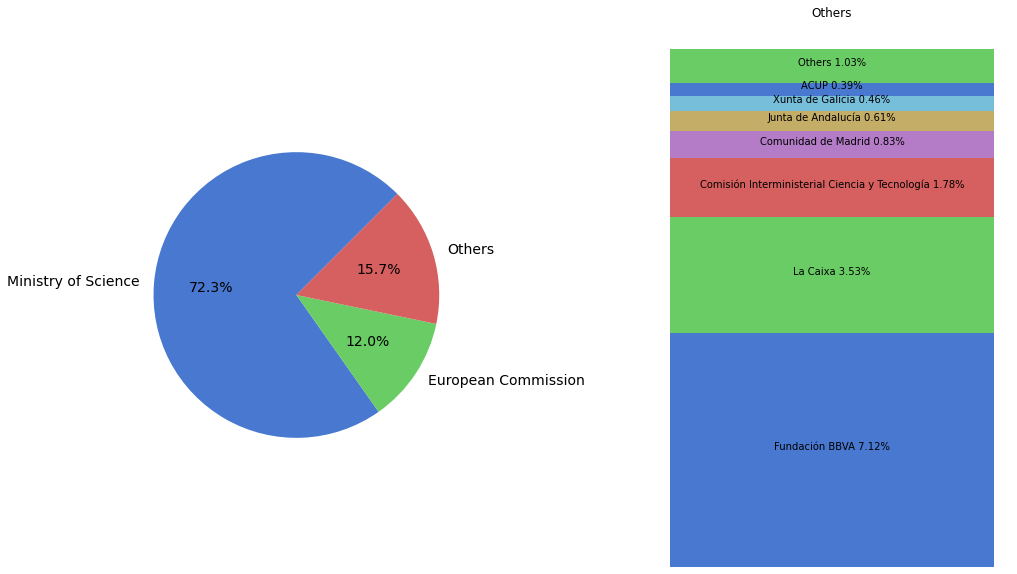

In [6]:
# from https://matplotlib.org/gallery/pie_and_polar_charts/bar_of_pie.html?highlight=bar%20pie
fig = plt.figure(figsize=(16,10))
fig.subplots_adjust(wspace=0.5)

# pie chart 
ax1 = plt.subplot(121)
df1.plot(kind='pie', y = 'pcts', ax=ax1, autopct='%1.1f%%', 
    startangle=45, shadow=False, labels=df1['financing_entity'], legend = False, fontsize=14)
ax1.axis('off')

# bar chart 
ax2 = fig.add_subplot(122)

xpos = 0
bottom = 0
labels = df2["financing_entity"].tolist()
pcts = df2["pcts"].tolist()
width = 1

for j in range(len(labels)):
    height = pcts[j]
    label = labels[j]
    ax2.bar(xpos, height, width, bottom=bottom)
    ypos = bottom + ax2.patches[j].get_height() / 2
    bottom += height
    # ax2.text(xpos, ypos, label + " %d%%" % (ax2.patches[j].get_height() * 100), ha='center')
    ax2.text(xpos, ypos, f"{label} {height*100:.2f}%", ha='center')

ax2.set_title('Others')
ax2.axis('off')

plt.show()


In [7]:
df1 = df1[df1["entidad"] != "Otros"]
df3 = pd.concat([df1, df2])
df3['pcts']= df3['pcts']*100
df3

,entidad,pcts,financing_entity
0,Ministerio de Ciencia,72.262854,Ministry of Science
1,Comisión Europea,11.990850,European Commission
0,Fundación BBVA,7.117738,Fundación BBVA
1,La Caixa,3.526702,La Caixa
2,Comisión Interministerial de Ciencia y Tecnología,1.782005,Comisión Interministerial Ciencia y Tecnología
3,Comunidad de Madrid,0.832429,Comunidad de Madrid
4,Junta de Andalucía,0.610613,Junta de Andalucía
5,Xunta de Galicia,0.458319,Xunta de Galicia
6,Asociación Catalana de Universidades Públicas ...,0.393175,ACUP
7,Otros,1.025314,Others
